Describe

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
path_des = "/content/drive/MyDrive/capstone/ml code (celia iseng)/describe/Symptom2Disease.csv"
df_des = pd.read_csv(path_des)

In [ ]:
!pip install rake-nltk
import nltk
from rake_nltk import Rake
nltk.download('stopwords')
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
#remove function
def keywords(text):
  key_arr = []
  r = Rake()
  r.extract_keywords_from_text(text)
  for rating, keyword in r.get_ranked_phrases_with_scores():
    key_arr.append(keyword)
  return key_arr

def sen(arr):
  s = " ".join([str(item) for item in arr])
  return s

In [ ]:
sentences_des = []
for i in df_des['text'].values.tolist():
  sentences_des.append(sen(keywords(i)))

In [ ]:
des_diseases = df_des['label']

Ceklis

In [ ]:
path_check = "/content/drive/MyDrive/capstone/ml code (celia iseng)/checklist/dataset.csv"
df_check = pd.read_csv(path_check)

In [ ]:
symptoms_check = df_check.drop(columns=['Disease'])

In [ ]:
import numpy as np
symptoms_check = symptoms_check.to_numpy()
sentences_check = []
for i in symptoms_check:
  #print(i)
  s = " ".join([str(item).replace("_", " ") for item in i if str(item) != "nan"])
  sentences_check = np.append(sentences_check,s)

In [ ]:
sentences_check = sentences_check.tolist()

In [ ]:
check_diseases = df_check['Disease']

In [ ]:
des_diseases = des_diseases.values.tolist()
check_diseases = check_diseases.values.tolist()

menggabungkan dataset

In [ ]:
sentences = sentences_check + sentences_des
diseases = check_diseases + des_diseases

In [ ]:
df = {'Diseases': diseases,'sentences': sentences}
df = pd.DataFrame(df)
print(df) 

              Diseases                                          sentences
0     Fungal infection  itching  skin rash  nodal skin eruptions  disc...
1     Fungal infection   skin rash  nodal skin eruptions  dischromic  ...
2     Fungal infection  itching  nodal skin eruptions  dischromic  pat...
3     Fungal infection            itching  skin rash  dischromic  patches
4     Fungal infection           itching  skin rash  nodal skin eruptions
...                ...                                                ...
6115          diabetes  occasionally get palpitations speeding heart t...
6116          diabetes  cuts take skin rashes skin bruises skin well p...
6117          diabetes  frequently feel drowsy also significantly lost...
6118          diabetes  urinary tract infections yeast infections trou...
6119          diabetes  usually gets better dry cough constantly sneez...

[6120 rows x 2 columns]


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
def label_encode(labels):
    label_encoder.fit(labels)
    label_sequences = label_encoder.transform(labels)
    return label_sequences

df['label_encoded'] = label_encode(df['Diseases'])

In [ ]:
df = df.drop(df[df["label_encoded"]==43].index)
df = df.drop(df[df["label_encoded"]==44].index)
df = df.drop(df[df["label_encoded"]==45].index)
df = df.drop(df[df["label_encoded"]==48].index)
df = df.drop(df[df["label_encoded"]==49].index)

In [ ]:
print(len(df.Diseases.unique()))
print((df.Diseases.unique()))

45
['Fungal infection' 'Allergy' 'GERD' 'Chronic cholestasis' 'Drug Reaction'
 'Peptic ulcer diseae' 'AIDS' 'Diabetes ' 'Gastroenteritis'
 'Bronchial Asthma' 'Hypertension ' 'Migraine' 'Cervical spondylosis'
 'Paralysis (brain hemorrhage)' 'Jaundice' 'Malaria' 'Chicken pox'
 'Dengue' 'Typhoid' 'hepatitis A' 'Hepatitis B' 'Hepatitis C'
 'Hepatitis D' 'Hepatitis E' 'Alcoholic hepatitis' 'Tuberculosis'
 'Common Cold' 'Pneumonia' 'Dimorphic hemmorhoids(piles)' 'Heart attack'
 'Varicose veins' 'Hypothyroidism' 'Hyperthyroidism' 'Hypoglycemia'
 'Osteoarthristis' 'Arthritis' '(vertigo) Paroymsal  Positional Vertigo'
 'Acne' 'Urinary tract infection' 'Psoriasis' 'Impetigo' 'Varicose Veins'
 'Dimorphic Hemorrhoids' 'Hypertension' 'gastroesophageal reflux disease']


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(df['sentences'].values.tolist(),df['label_encoded'].values.tolist(), test_size = 0.2, random_state=1)

In [ ]:
vocab_size = 2000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(x_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(x_val)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

In [ ]:
def create_model(vocab_size, embedding_dim, max_length):
  model = models.Sequential([
  layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
  layers.GlobalAveragePooling1D(),
  layers.Dense(24, activation='relu'),
  Dropout(0.2),
  layers.Dense(50, activation='softmax')
  ])

  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=optimizers.Adam(),
                metrics=['accuracy'])
  
  return model

In [ ]:
model = create_model(vocab_size, embedding_dim, max_length)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           32000     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                1250      
                                                                 
Total params: 33,658
Trainable params: 33,658
Non-trainable params: 0
____________________________________________________

In [ ]:
train_labels = np.array(y_train)
validation_labels = np.array(y_val)
train_labels = train_labels.reshape(len(train_labels), 1)
validation_labels = validation_labels.reshape(len(validation_labels), 1)

In [ ]:
num_epochs = 100
history = model.fit(train_padded, train_labels, 
                    epochs=num_epochs, 
                    validation_data=(validation_padded, validation_labels))

Epoch 1/100
147/147 [==============================] - 2s 8ms/step - loss: 3.8887 - accuracy: 0.0300 - val_loss: 3.8537 - val_accuracy: 0.0315
Epoch 2/100
147/147 [==============================] - 1s 8ms/step - loss: 3.8108 - accuracy: 0.0366 - val_loss: 3.7810 - val_accuracy: 0.0179
Epoch 3/100
147/147 [==============================] - 2s 11ms/step - loss: 3.7536 - accuracy: 0.0415 - val_loss: 3.7236 - val_accuracy: 0.0375
Epoch 4/100
147/147 [==============================] - 1s 8ms/step - loss: 3.6762 - accuracy: 0.0564 - val_loss: 3.6111 - val_accuracy: 0.0392
Epoch 5/100
147/147 [==============================] - 1s 7ms/step - loss: 3.5142 - accuracy: 0.0839 - val_loss: 3.3921 - val_accuracy: 0.0894
Epoch 6/100
147/147 [==============================] - 1s 6ms/step - loss: 3.3008 - accuracy: 0.1171 - val_loss: 3.1248 - val_accuracy: 0.1457
Epoch 7/100
147/147 [==============================] - 1s 7ms/step - loss: 3.0406 - accuracy: 0.1799 - val_loss: 2.8280 - val_accuracy: 0.257

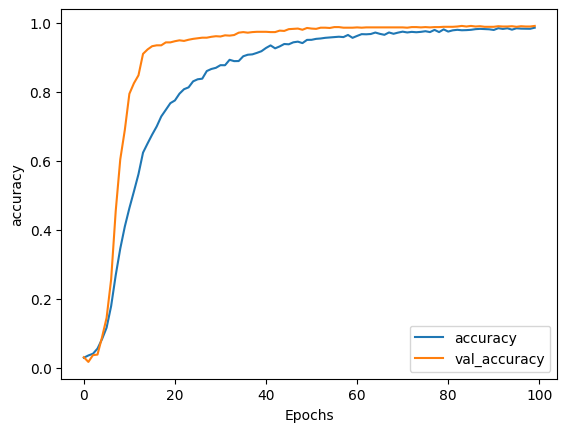

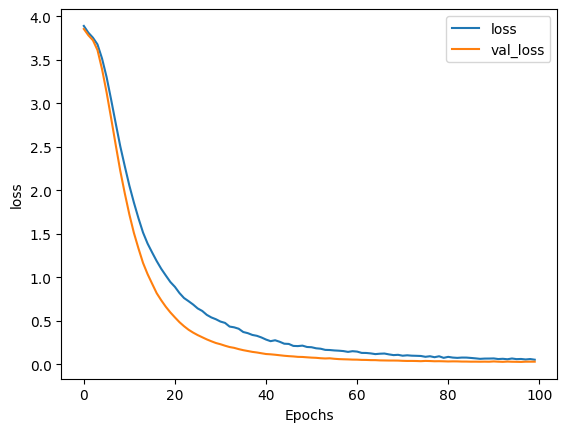

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
from sklearn.metrics import classification_report
pred = model.predict(validation_padded, batch_size=32, verbose=1)
predicted = np.argmax(pred, axis=1)
report = classification_report(validation_labels, predicted)
print(report)

37/37 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        17
           2       0.97      1.00      0.99        35
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        26
           5       1.00      1.00      1.00        34
           6       1.00      0.97      0.99        34
           7       1.00      1.00      1.00        34
           8       0.97      0.94      0.96        36
           9       1.00      1.00      1.00        20
          10       1.00      0.97      0.98        32
          11       0.92      1.00      0.96        34
          12       1.00      1.00      1.00        20
          13       1.00      1.00      1.00         6
          14       1.00      1.00      1.00        29
          15       1.00      1.00      1.00        22
          16       0.97     

In [ ]:
test1 = ["I have been experiencing a skin rash on my arms, legs, and torso for the past few weeks. It is red, itchy, and covered in dry, scaly patches.","I have a sudden high fever accompanied by bone and muscle pain. I also feel extremely tired and have lost my appetite. I experience severe headaches, particularly behind my eyes. I have mild bleeding from the nose or gums, and there are red rashes appearing on my skin.", "halo", "ts, coba coba asal", "ngasal dulu ah", "aaaaaaaaaa", "My lymph nodes are swollen, causing discomfort in my neck and armpits. I don't know what's causing it.", "I feel tired every day. There are red spots all over my arms and back and it itches if I touch them. I am really worried and not sure what to do."]

In [ ]:
testing = []
for i in test1:
  testing.append(sen(keywords(i)))

In [ ]:
test_sequences = tokenizer.texts_to_sequences(testing)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

In [ ]:
prediction = model.predict_on_batch(
    test_padded
)

In [ ]:
for i in prediction:
  unsure=False
  print(np.max(i))
  if np.max(i)<0.55:
    unsure=True
    print("Can't be diagnosed")
  else:
    top_3 = np.argsort(i)[-3:][::-1]
    print(label_encoder.inverse_transform(top_3))
    print(top_3)

0.98963416
['Psoriasis' 'Acne' 'Impetigo']
[37  2 29]
0.59591365
['Dengue' 'Typhoid' 'Common Cold']
[11 39 10]
0.47749028
Can't be diagnosed
0.48938292
Can't be diagnosed
0.48545778
Can't be diagnosed
0.47749028
Can't be diagnosed
0.86542886
['Chicken pox' 'Allergy' 'Hypertension']
[ 8  4 24]
0.96116185
['Chicken pox' 'Dengue' 'Allergy']
[ 8 11  4]


In [ ]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1
  Attempting uninstall: flax
    Found existing installation: flax 0.6.9
    Uninstalling flax-0.6.9:
      Successfully uninstalled flax-0.6.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statsmodels 0.13.5 requires packaging>=21.3, but you have packaging 20.9 which is incompatible.
xar

In [ ]:
import tensorflowjs as tfjs
filepath = "/content/drive/MyDrive/capstone/ml code (celia iseng)/Eksperimen~~/model experimen 4/model.h5"
model.save(filepath, save_format='h5')
tfjs.converters.save_keras_model(model, "/content/drive/MyDrive/capstone/ml code (celia iseng)/Eksperimen~~/model experimen 4/")

In [ ]:
word_index = tokenizer.word_index
index_to_word = {index: word for word, index in word_index.items()}
dict_input = pd.DataFrame.from_dict(index_to_word, orient='index', columns=['Word'])
csv_filename = '/content/drive/MyDrive/capstone/ml code (celia iseng)/Eksperimen~~/model experimen 4/dict_input.csv'
dict_input.to_csv(csv_filename)
label_mapping = {label: encoded_label for label, encoded_label in zip(df['Diseases'].tolist(),df['label_encoded'].tolist())}
dict_output = pd.DataFrame.from_dict(label_mapping, orient='index', columns=['EncodedLabel'])
dict_output.index.name = 'OriginalLabel'
csv_filename = '/content/drive/MyDrive/capstone/ml code (celia iseng)/Eksperimen~~/model experimen 4/dict_output.csv'
dict_output.to_csv(csv_filename)